In [44]:
%matplotlib inline
import os
import re
import io
import itertools

import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import xarray as xr

import climatools.html.html as climahtml
from climatools.lblnew.dataio import *
from climatools.plot.plot import *


import IPython.display as display


In [45]:
DIR_FORTRAN = os.path.join('/chia_cluster/home/jackyu/radiation',
                           'clirad-lw/LW/examples/lblnew/now')

In [46]:
PATH_FLUX = os.path.join(DIR_FORTRAN, 'output_flux.dat')
PATH_COOLR = os.path.join(DIR_FORTRAN, 'output_coolr.dat')

In [47]:
def load_lblnew_output_file(path_csv):
    '''
    Load lblnew output .csv file to xarray.Dataset
    
    Parameters
    ----------
    path_csv: str
              Path to the .csv file to be loaded.
    ds: xarray.Dataset
        Data in the input file in the form of an xarray.Dataset.
    '''
    toindex = ['band', 'pressure']    
    df = pd.read_csv(path_csv, sep=r'\s+')
    df = df.set_index([i for i in toindex if i in df.columns])
    ds = xr.Dataset.from_dataframe(df)
    return ds

In [48]:
DS_FLUX = load_lblnew_output_file(PATH_FLUX)
DS_COOLR = load_lblnew_output_file(PATH_COOLR)

In [49]:
DS_FLUX

<xarray.Dataset>
Dimensions:   (band: 10, pressure: 76)
Coordinates:
  * band      (band) int64 1 2 3 4 5 6 7 8 9 10
  * pressure  (pressure) float64 0.0 0.0006244 0.0008759 0.001229 0.001723 ...
Data variables:
    level     (band, pressure) int64 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 ...
    sfu       (band, pressure) float64 -43.96 -43.98 -44.01 -44.05 -44.1 ...
    sfd       (band, pressure) float64 8.194 8.194 8.219 8.251 8.293 8.336 ...
    fnet      (band, pressure) float64 -35.76 -35.79 -35.79 -35.8 -35.8 ...

In [50]:
DS_COOLR

<xarray.Dataset>
Dimensions:   (band: 10, pressure: 75)
Coordinates:
  * band      (band) int64 1 2 3 4 5 6 7 8 9 10
  * pressure  (pressure) float64 0.0003122 0.0007501 0.001052 0.001476 ...
Data variables:
    layer     (band, pressure) int64 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 ...
    coolr     (band, pressure) float64 0.0 -323.5 -225.8 -232.3 -13.47 ...

In [51]:
def pltdata_cooling(ds_coolr=None):
    data = [{'label': 'CLIRAD',
             'linestyle': ':', 'color': 'green', 'marker': 'D',
             'srs': ds_coolr['coolr'].sel(band=1)}]
    return data


def plt_cooling(pltdata=None):
    '''
    Plots a list of cooling rate profiles.
    
    Parameter
    ---------
    pltdata: list-like
             List of dictionaries each of which contains the following
             fields:
                 label -- 
    '''
    
    plot_args = {'index_on_yaxis': True,
                 'yincrease': False,
                 'linewidth': 2,
                 'grid': True,
                 'alpha': .7}
    
    yscales = ['linear', 'log']
    varlims = [(50, 1050), (1e-2, 200)]
    
    fig, axs = plt.subplots(ncols=len(yscales), nrows=1,
                            figsize=(15, 6))
    
    axs = axs.flatten()
    
    for ax, yscale, varlim in zip(axs, yscales, varlims):
        for d in pltdata:
            d['srs'].climaviz.plot(ax=ax,
                                  yscale=yscale,
                                   varlim_from_indexrange=varlim,
                                  label=d['label'],
                                  linestyle=d['linestyle'],
                                  color=d['color'],
                                  marker=d['marker'],
                                  **plot_args)
            
        ax.set_title('')
        
        ax.set_ylabel('Pressure (mb)')
        ax.set_ylim(top=1e-2)
        ax.set_ylim(bottom=None)
    
        ax.set_xlabel('Cooling rate (degree per day)')
    return fig, axs



def script_plt_cooling():

    matplotlib.rcParams.update({'font.size': 13,
                            'grid.color': 'grey',
                            'axes.facecolor': 'white',
                            'axes.edgecolor': 'black',
                            'ytick.direction': 'out',
                            'ytick.major.size': 6, 'ytick.major.width': 1,
                            'ytick.minor.size': 3, 'ytick.minor.width': 1,
                            'xtick.direction': 'out',
                            'xtick.major.size': 6, 'xtick.major.size': 1,
                            'xtick.minor.size': 3, 'xtick.minor.size': 1}) 

    pltdata = pltdata_cooling(ds_coolr=DS_COOLR,)

    fig, axs = plt_cooling(pltdata=pltdata)
    
    display.display(fig)
    print('Figure: Cooling rate profile comparison.')
    
    plt.close(fig)

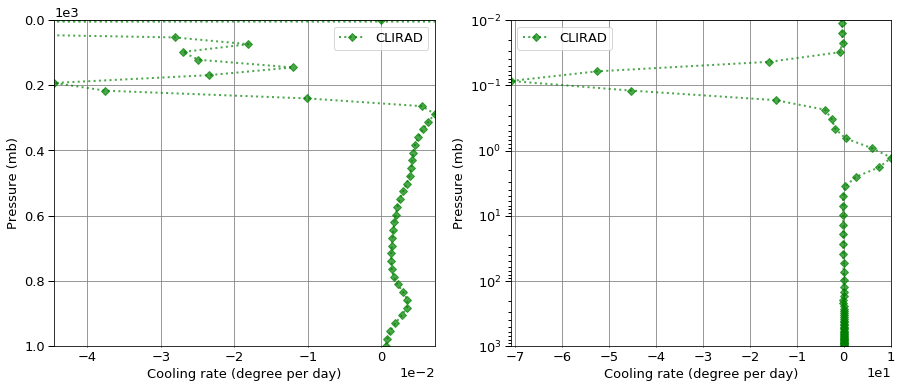

Figure: Cooling rate profile comparison.


In [52]:
script_plt_cooling()

In [53]:
pd.set_option('display.max_rows', None)
display.display(DS_FLUX.sel(band=1).to_dataframe())
pd.reset_option('display.max_rows')

,band,level,sfu,sfd,fnet
pressure,,,,,
0.000000,1,1,-43.956360,8.193699,-35.762661
0.000624,1,2,-43.981091,8.194499,-35.786591
0.000876,1,3,-44.012268,8.218946,-35.793320
0.001229,1,4,-44.054279,8.251254,-35.803024
0.001723,1,5,-44.097172,8.293359,-35.803814
0.002417,1,6,-44.140213,8.336260,-35.803955
0.003391,1,7,-44.183384,8.379305,-35.804077
0.004757,1,8,-44.226688,8.422484,-35.804203
0.006672,1,9,-44.270126,8.465796,-35.804329


In [54]:
display.HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')